In [1]:
#This notebook details the data preprocessing pipeline I used. 
#This isn't very formalized as I quite often went back and form in a data
#exploratory way in order to figure out the right order of precedence.

import pickle
import preprocessing
import pandas as pd
import nltk
import re
import data_formatting

from joblib import Parallel, delayed

import numpy as np

import seaborn as sns
import string

def stripLineBreak(x):
    return x.replace('\n', '')

def createConversations(all_text):
    conv = [[all_text[idx_text], all_text[idx_text+1]] for idx_text, text in enumerate(all_text[:-1])]
    return conv

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#dataset = 'de_en'
#t_enc = open(r'C:\Users\euix\nmt_data\wmt16_de_en\train.en', 'r', encoding='utf8')
#t_dec = open(r'C:\Users\euix\nmt_data\wmt16_de_en\train.de', 'r', encoding='utf8')

#t_enc = t_enc.readlines()
#t_dec = t_dec.readlines()

In [ ]:
#Raw data is converted to a dataframe of two columns representing encoder and decoder inputs
dataset = 'twitter'
#twitter_data = open('../../datasets/chat.txt', 'r', encoding='utf-8')
twitter_data = open('../../datasets/chat_corpus/cleaned_corpus_en.txt', 'r', encoding='utf-8')

twitter_lines = twitter_data.readlines()

twitter_convs = [[line for idx, line in enumerate(twitter_lines) if idx%2==1], 
              [line for idx, line in enumerate(twitter_lines) if idx%2==0]]

df_all = pd.DataFrame(list(zip(*twitter_convs)), columns=['Pair_0', 'Pair_1']) 

In [ ]:
print ('rows of data', df_all.shape[0])

In [ ]:
#df_all = df_all.sample(frac=1, random_state=0)

In [ ]:
#Remove non-alphanumeric characters and strip any line breaks

df_all['Pair_0'] = df_all['Pair_0'].apply(preprocessing.remove_non_ascii)

df_all['Pair_1'] = df_all['Pair_1'].apply(preprocessing.remove_non_ascii)

df_all['Pair_0'] = df_all['Pair_0'].apply(stripLineBreak)

df_all['Pair_1'] = df_all['Pair_1'].apply(stripLineBreak)

In [6]:
#Check and remove all non-alphanumeric characters except end sentence chars (i.e. !, ?)
Pair_0_char_checked = Parallel(n_jobs=-1, verbose=8)(delayed(preprocessing.checkChars)(i) for i in df_all['Pair_0'].values)
Pair_1_char_checked = Parallel(n_jobs=-1, verbose=8)(delayed(preprocessing.checkChars)(i) for i in df_all['Pair_1'].values)

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 38733 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 170543 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 329253 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 509483 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 716613 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 945263 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 1200813 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 1477883 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 1781853 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done 2107343 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 2459733 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 2601244 out of 2601244 | elapsed:   51.4s finished
[Parallel(n_jobs

In [7]:
df_all['Pair_0_char_checked'] = Pair_0_char_checked

df_all['Pair_1_char_checked'] = Pair_1_char_checked

In [8]:
Pair_0_char_checked = []
Pair_1_char_checked = []

In [9]:
#Word tokenize each sentence, count the length and append <EOS> char
alpha_Pair_0_tokens = Parallel(n_jobs=-1, verbose=8)(\
                            delayed(preprocessing.checkAlphaLower)(i) for i in df_all['Pair_0_char_checked'].values)

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 10887 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 40189 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 75471 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 115537 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 161583 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 212413 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 269223 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 330817 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 398391 tasks      | elapsed:   49.6s
[Parallel(n_jobs=-1)]: Done 470749 tasks      | elapsed:   56.8s
[Parallel(n_jobs=-1)]: Done 549087 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 632209 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 721311 ta

In [10]:
alpha_Pair_1_tokens = Parallel(n_jobs=-1, verbose=8)(\
                            delayed(preprocessing.checkAlphaLower)(i) for i in df_all['Pair_1_char_checked'].values)

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 9707 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 38911 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 74075 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 114007 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 159899 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 210559 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 267179 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done 328567 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done 395915 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done 459389 tasks      | elapsed:   56.8s
[Parallel(n_jobs=-1)]: Done 498427 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 539849 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 584251 tas

In [11]:
df_all['alpha_Pair_0_tokens'] = list(zip(*alpha_Pair_0_tokens))[0]

df_all['alpha_Pair_1_tokens'] = list(zip(*alpha_Pair_1_tokens))[0]

In [12]:
df_all['n_alpha_Pair_0_tokens'] = list(zip(*alpha_Pair_0_tokens))[1]

df_all['n_alpha_Pair_1_tokens'] = list(zip(*alpha_Pair_1_tokens))[1]

In [13]:
alpha_Pair_0_tokens = []
alpha_Pair_1_tokens = []

In [14]:
#Strip rows that are now empty
df_all = df_all[df_all['n_alpha_Pair_0_tokens'] != 0]

df_all = df_all[df_all['n_alpha_Pair_1_tokens'] != 0]

In [15]:
#Stem word tokens
alpha_stem_Pair_0_tokens = Parallel(n_jobs=-1, verbose=8)(\
                            delayed(preprocessing.nltkStem)(i) for i in df_all['alpha_Pair_0_tokens'].values)

df_all['alpha_stem_Pair_0_tokens'] = list(zip(*alpha_stem_Pair_0_tokens))[0]
df_all['n_alpha_stem_Pair_0_tokens'] = list(zip(*alpha_stem_Pair_0_tokens))[1]

alpha_stem_Pair_1_tokens = Parallel(n_jobs=-1, verbose=8)(\
                            delayed(preprocessing.nltkStem)(i) for i in df_all['alpha_Pair_1_tokens'].values)

df_all['alpha_stem_Pair_1_tokens'] = list(zip(*alpha_stem_Pair_1_tokens))[0]

df_all['n_alpha_stem_Pair_1_tokens'] = list(zip(*alpha_stem_Pair_1_tokens))[1]

alpha_stem_quote_tokens = []
alpha_stem_quote_tokens = []

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 11260 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 49774 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 96148 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 148810 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 209332 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 276142 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done 346096 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 386575 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 430984 tasks      | elapsed:   46.0s
[Parallel(n_jobs=-1)]: Done 478537 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-1)]: Done 530020 tasks      | elapsed:   53.9s
[Parallel(n_jobs=-1)]: Done 584647 tasks      | elapsed:   58.3s
[Parallel(n_jobs=-1)]: Done 643204 ta

In [16]:
#Lemmatize tokens, note I am applying this separately to stemming, to further vocabulary one could apply stemming
#and lemmatization at the cost of comprehension

alpha_lem_Pair_0_tokens = Parallel(n_jobs=-1, verbose=8)(\
                            delayed(preprocessing.nltkLem)(i) for i in df_all['alpha_Pair_0_tokens'].values)

df_all['alpha_lem_Pair_0_tokens'] = list(zip(*alpha_lem_Pair_0_tokens))[0]
df_all['n_alpha_lem_Pair_0_tokens'] = list(zip(*alpha_lem_Pair_0_tokens))[1]

alpha_lem_Pair_1_tokens = Parallel(n_jobs=-1, verbose=8)(\
                            delayed(preprocessing.nltkLem)(i) for i in df_all['alpha_Pair_1_tokens'].values)

df_all['alpha_lem_Pair_1_tokens'] = list(zip(*alpha_lem_Pair_1_tokens))[0]

df_all['n_alpha_lem_Pair_1_tokens'] = list(zip(*alpha_lem_Pair_1_tokens))[1]

alpha_lem_quote_tokens = []
alpha_lem_quote_tokens = []

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 34554 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 105211 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 190588 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 289212 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 402556 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 527676 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 667516 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done 819132 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 985468 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1078204 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1174620 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1276924 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1386

In [34]:
def chunkPickleSave(data, save_path, chunks):
    chunk_size = int(len(data)/chunks)
    print (chunk_size)
    for i in range(chunks):
        
        if i != chunks-1:
            data[i*chunk_size:(i+1)*chunk_size].to_pickle(save_path + '_part_%d.pkl' % i)
        
        else:
            data[i*chunk_size:].to_pickle(save_path + '_part_%d.pkl' % i)
        

In [36]:
chunkPickleSave(df_all, 
                '../../datasets/%s_preprocess_pickle_stage_0_sample_%d' % (dataset, df_all.shape[0]), 10)

260124


In [20]:
#df_all.to_hdf('../../datasets/%s_reprocess_pickle_stage_0_sample_%d_questions_only.h5' % (dataset, df_all.shape[0]), key='data')

In [2]:
df_all = pd.read_pickle('../../datasets/twitter_preprocess_pickle_stage_0_sample_333769_questions_only.pkl')

In [3]:
df_all.head(2)

,Pair_0,Pair_1,Pair_0_char_checked,Pair_1_char_checked,alpha_Pair_0_tokens,alpha_Pair_1_tokens,n_alpha_Pair_0_tokens,n_alpha_Pair_1_tokens,alpha_stem_Pair_0_tokens,n_alpha_stem_Pair_0_tokens,alpha_stem_Pair_1_tokens,n_alpha_stem_Pair_1_tokens,alpha_lem_Pair_0_tokens,n_alpha_lem_Pair_0_tokens,alpha_lem_Pair_1_tokens,n_alpha_lem_Pair_1_tokens
0,the paranoia has already began...why do they t...,whitney- i dont think shane wants to work with...,the paranoia has already began...why do they t...,whitney i dont think shane wants to work with...,"[the, paranoia, has, already, began, why, do, ...","[whitney, i, dont, think, shane, wants, to, wo...",27,28,"[the, parano, has, already, beg, why, do, they...",27,"[whitney, i, dont, think, shan, want, to, work...",28,"[the, paranoia, ha, already, began, why, do, t...",27,"[whitney, i, dont, think, shane, want, to, wor...",28
13,ya omg really how'd you think of that one??,that's deep.....how's you think of such a deep...,ya omg really how d you think of that one??,that s deep.....how s you think of such a deep...,"[ya, omg, really, how, d, you, think, of, that...","[that, s, deep, how, s, you, think, of, such, ...",13,21,"[ya, omg, real, how, d, you, think, of, that, ...",13,"[that, s, deep, how, s, you, think, of, such, ...",21,"[ya, omg, really, how, d, you, think, of, that...",13,"[that, s, deep, how, s, you, think, of, such, ...",21


In [4]:
processing_type='stem'
pair_0 = 'alpha_%s_Pair_0_tokens' % processing_type
pair_1 = 'alpha_%s_Pair_1_tokens' % processing_type

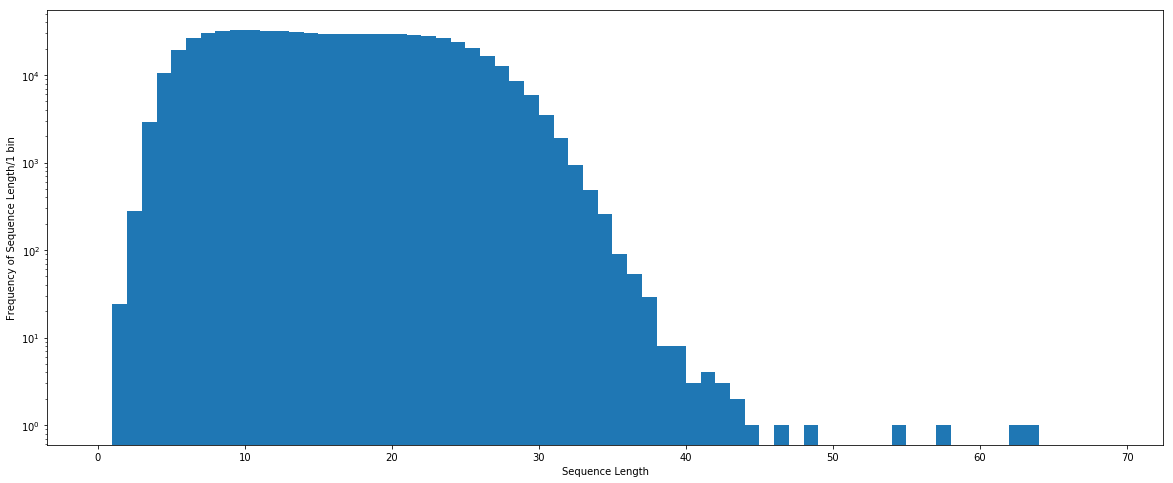

In [5]:
sent_lengths = sum([list(df_all['n_' + pair_0].values), \
                    list(df_all['n_' + pair_1].values)], [])
plt.figure(figsize=(20, 8))
plt.hist(sent_lengths, log=True, bins=[i for i in range(70)])
plt.xlabel('Sequence Length')
plt.ylabel('Frequency of Sequence Length/1 bin')
plt.savefig('SequenceFrequency.png')

In [6]:
#Filter for sequences of minimum and maximum length
df_all = df_all[(df_all['n_' + pair_0]>3) & (df_all['n_' + pair_1]>3)]

df_all = df_all[(df_all['n_' + pair_0]<21) & (df_all['n_' + pair_1]<21)]

In [7]:
print ('Rows retained', df_all.shape[0])

Rows retained 185246


In [8]:
flat_list_pair_0 = [item for sublist in df_all[pair_0].values for item in sublist]

flat_list_pair_1 = [item for sublist in df_all[pair_1].values for item in sublist]

flat_list = flat_list_pair_0 + flat_list_pair_1

fdist_quote = nltk.FreqDist(flat_list)

words = fdist_quote.keys()

word_counts = fdist_quote.values()

df_all_word_counts = pd.DataFrame(list(zip(words, word_counts)), columns=['word', 'word_counts'])

In [9]:
df_all_word_counts.sort_values(by=['word_counts'], ascending=True, inplace=True)

In [10]:
df_all_word_counts.groupby('word_counts').count().head()

,word
word_counts,
1,27866
2,6494
3,3135
4,1982
5,1433


In [11]:
df_all_word_counts = df_all_word_counts[df_all_word_counts['word'].isin(['<eos>', '?']) == False]

In [12]:
df_all_word_counts['word_counts_norm'] = df_all_word_counts['word_counts']/df_all_word_counts['word_counts'].sum()

In [13]:
n_grams = [Parallel(n_jobs=-1, verbose=8)(\
                delayed(preprocessing.nltkNGram)(text, n_gram) for text in df_all['alpha_lem_Pair_1_tokens'].values) for
          n_gram in range(2, 3, 1)]

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 42589 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 185246 out of 185246 | elapsed:   12.4s finished


In [15]:
q = [i for j in n_grams[0] for i in j]

In [16]:
q

[('whewwww', 'this'),
 ('this', 'wa'),
 ('wa', 'a'),
 ('a', 'lot'),
 ('lot', 'a'),
 ('a', 'hard'),
 ('hard', 'heavy'),
 ('heavy', 'relatable'),
 ('relatable', 'read'),
 ('read', 'tw'),
 ('tw', 'suicide'),
 ('suicide', 'suicide'),
 ('suicide', 'thought'),
 ('thought', 'description'),
 ('description', 'of'),
 ('of', 'self'),
 ('self', 'harm'),
 ('harm', '<EOS>'),
 ('donald', 'trump'),
 ('trump', 'shame'),
 ('shame', 'ex'),
 ('ex', 'miss'),
 ('miss', 'universe'),
 ('universe', 'for'),
 ('for', 'her'),
 ('her', 'sexual'),
 ('sexual', 'past'),
 ('past', 'in'),
 ('in', 'late'),
 ('late', 'night'),
 ('night', 'twitter'),
 ('twitter', 'barrage'),
 ('barrage', '<EOS>'),
 ('god', 'i'),
 ('i', 've'),
 ('ve', 'used'),
 ('used', 'the'),
 ('the', 'i'),
 ('i', 'have'),
 ('have', 'to'),
 ('to', 'find'),
 ('find', 'a'),
 ('a', 'save'),
 ('save', 'spot'),
 ('spot', 'excuse'),
 ('excuse', 'with'),
 ('with', 'all'),
 ('all', 'the'),
 ('the', 'time'),
 ('time', '<EOS>'),
 ('is', 'a'),
 ('a', 'globalist'),


In [49]:
word_sets = [set(df_all_word_counts[df_all_word_counts['word_counts']==i]['word'].values) for i in range(1, 22, 1)]

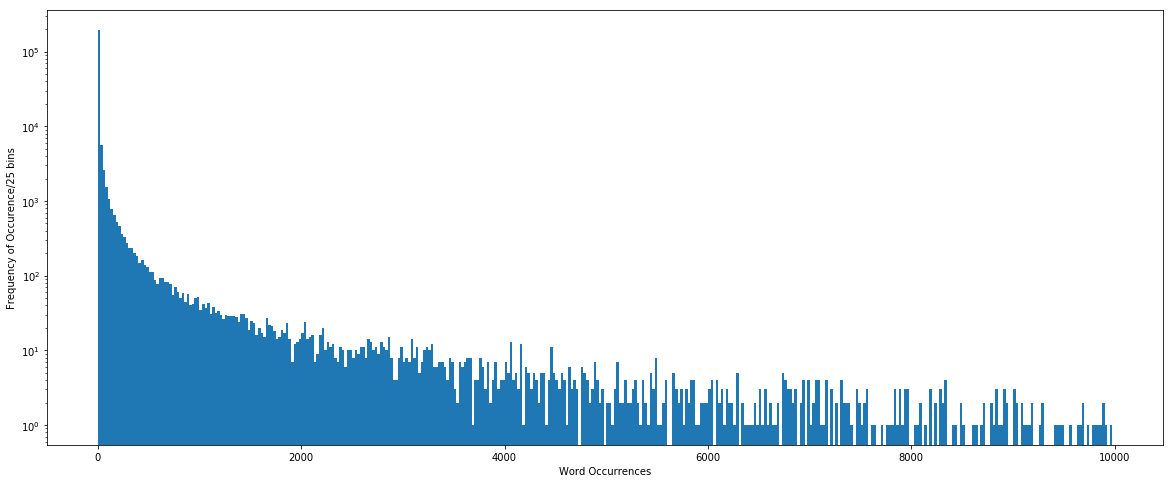

In [50]:
plt.figure(figsize=(20, 8))
plt.hist(df_all_word_counts['word_counts'].values, bins=[i for i in range(1, 10000, 25)], log=True)
plt.xlabel('Word Occurrences')
plt.ylabel('Frequency of Occurence/25 bins')
plt.savefig('WordFrequency.png')

In [13]:
#Check for occurrence of rare words in each sentence and tag sentences where rare words occur

In [55]:
for i in range(0, 20, 1):

    func_length = lambda x: preprocessing.checkWordOccurrenceLength(x, i, word_sets[i])

    df_all['n_' + pair_0 + '_%d_word' % (i+1)] = df_all[pair_0].apply(func_length)

    df_all['n_' + pair_1 + '_%d_word' % (i+1)] = df_all[pair_1].apply(func_length)

In [56]:
#Remove sequence pairs contain rarely occuring words,
rare_word_lower_bound = 10
for i in range(1, rare_word_lower_bound, 1):
    df_all = df_all[
		(df_all['n_' + pair_0 + '_%d_word' % i]==0) &
		(df_all['n_' + pair_1 + '_%d_word' % i]==0)] 

In [57]:
Pair_0_words = set.union(*[set(i) for i in df_all[pair_0].values])

Pair_1_words = set.union(*[set(i) for i in df_all[pair_1].values])

In [58]:
vocab_set = Pair_0_words.union(Pair_1_words)

In [59]:
len(vocab_set)

31969

In [60]:
#We can continue to reduce the vocabulary further by assigning <UNK> tokens to a larger amount of rare tokens but
#preserve the sequences that they arise from as opposed to filtering them completely.
#vocab_set_sub = list(set(vocab_set) - set(df_all_word_counts[df_all_word_counts['word_counts']<20]['word'].values))
vocab_set_sub = list(set(vocab_set))

In [61]:
def createDict(word, count):
    if word!='<EOS>':
        if word not in vocab_set_sub: return {word : 2}
        else :return {word : count + 3} 
    else:
        return {word:1}

In [62]:
vocab_dict = [createDict(word, word_idx) for word_idx, word in enumerate(vocab_set_sub)]

In [63]:
vocab_dict = {k: v for d in vocab_dict for k, v in d.items()}

In [64]:
vocab_dict['<PAD>'] = 0
vocab_dict['<EOS>'] = 1
vocab_dict['<UNK>'] = 2

In [65]:
print ('size of vocab:%d, size of dataset:%d' % (len(vocab_dict), df_all.shape[0]))

size of vocab:31972, size of dataset:1276985


In [66]:
df_final = pd.DataFrame()

In [67]:
encode_sent = lambda x: data_formatting.encodeSent(x, vocab_dict)

In [68]:
df_final['alpha_Pair_1_encoding'] =  df_all[pair_0].apply(encode_sent)
df_final['alpha_Pair_0_encoding'] = df_all[pair_1].apply(encode_sent)

df_final['Index'] = df_all.index.values

In [70]:
seq_min = min(df_all['n_' + pair_0].min(), df_all['n_' + pair_1].min())
seq_max = min(df_all['n_' + pair_0].max(), df_all['n_' + pair_1].max())

print (seq_min, seq_max)

4 20


In [71]:
df_final.to_pickle(\
    '../processed_data/processed_data_v02_%s_py35_seq_length_%d_%d_sample_%d.pkl' % (dataset, seq_min, seq_max, df_all.shape[0]))

pickle.dump(vocab_dict, \
    open('../processed_data/word_dict_v02_%s_py35_seq_length_%d_%d_sample_%d.pkl' % (dataset, seq_min, seq_max, df_all.shape[0]) , 'wb'))